In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pylab
import seaborn as sns

In [2]:
import nltk

In [30]:
import sqlite3, json, re

In [4]:
RATIO = 0.618

### GET field names    

In [5]:
conn = sqlite3.connect('arxiv.db')
cursor = conn.cursor()

info = cursor.execute("PRAGMA TABLE_INFO(arxiv)")
field_names = [record[1] for record in info]
print(field_names)

cursor.close()
conn.close()

['abstract', 'authors', 'authors_parsed', 'categories', 'comments', 'doi', 'id', 'journal-ref', 'license', 'report-no', 'submitter', 'title', 'update_date', 'versions']


### SELECT categories and update_date from table

In [6]:
def get_date_and_cats():
    with sqlite3.connect('arxiv.db') as conn:
        cursor = conn.cursor()
        query = 'SELECT id, update_date, categories FROM arxiv ORDER BY update_date'
        query_result = cursor.execute(query)
        data = pd.DataFrame(query_result.fetchall())
        data.columns = ['id', 'update_date', 'categories']
        data = data.set_index(data.id).drop(columns=['id'])
        cursor.close()

    return data

In [7]:
data = get_date_and_cats()
data.head()

,update_date,categories
id,,
0704.0004,2007-05-23,math.CO
0704.0010,2007-05-23,math.CO
0704.0012,2007-05-23,math.NT
0704.0018,2007-05-23,hep-th
0704.0034,2007-05-23,q-bio.PE q-bio.CB quant-ph


In [8]:
data['year-month'] = data.update_date.str.extract(r'([0-9]+-[0-9]+)-[0-9]+')
data['year'] = data.update_date.str.extract(r'([0-9]+)-[0-9]+-[0-9]+')

In [9]:
year_groups = data.groupby('year').apply(len)
year_groups

year
2007    146648
2008     69535
2009    229386
2010     56492
2011     62190
2012     57709
2013     72579
2014     88881
2015    216670
2016    135461
2017    125866
2018    143191
2019    177383
2020    165316
dtype: int64

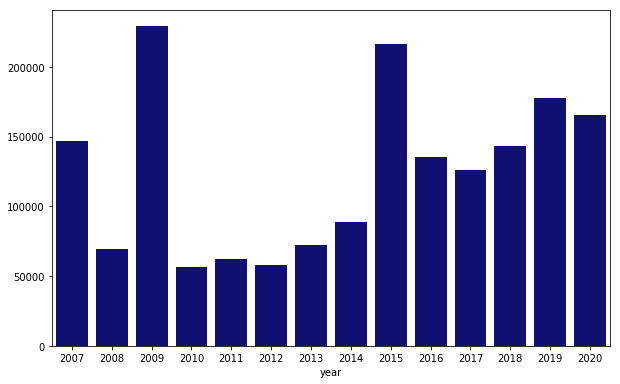

In [10]:
plt.figure(figsize=(10, 10*RATIO))
sns.barplot(x=year_groups.index, y=year_groups, color='navy')

### Top10 categories in arxiv

In [11]:
cate_series_raw = data.categories.str.split(' ')

In [12]:
cat_numbers = {}
for i in range(cate_series_raw.shape[0]):
    for cat in cate_series_raw[i]:
        cat_numbers[cat] = cat_numbers.get(cat,0) + 1

In [13]:
cate_se = pd.Series(cat_numbers, index=cat_numbers.keys())

In [14]:
# The top-10 categories
top10_cate = cate_se.sort_values(ascending=False)[:10]

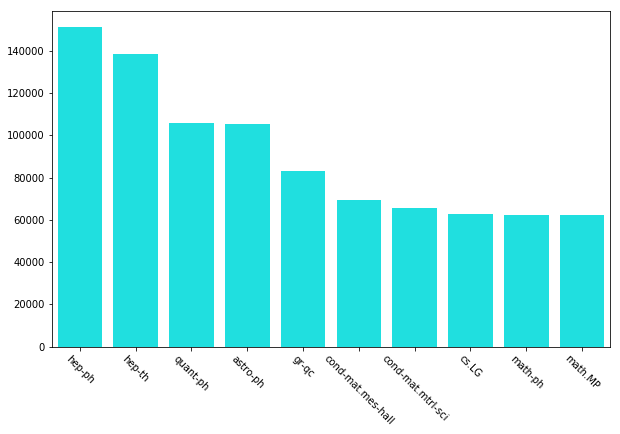

In [15]:
fig = plt.figure(figsize=(10, 10*RATIO))

ax = sns.barplot(x=top10_cate.index, y=top10_cate,color='aqua')
for tick in ax.get_xticklabels():
    tick.set_rotation(-45)

### Top authors in quant-ph category

In [16]:
def get_authors_in_quantph():
    with sqlite3.connect('arxiv.db') as conn:
        cursor = conn.cursor()
        query = '''SELECT id, update_date, authors 
                   FROM arxiv 
                   WHERE categories LIKE '%quant-ph%'
                   ORDER BY update_date'''
        query_result = cursor.execute(query)
        data = pd.DataFrame(query_result.fetchall())
        data.columns = ['id', 'update_date', 'authors']
        data = data.set_index(data.id).drop(columns=['id'])
        cursor.close()

    return data

In [17]:
data_author = get_authors_in_quantph()
data_author.head()

,update_date,authors
id,,
0704.0034,2007-05-23,Vasily Ogryzko
0704.0214,2007-05-23,Miloslav Znojil
0704.0340,2007-05-23,"Fam Le Kien, S. Dutta Gupta, and K. Hakuta"
0704.0373,2007-05-23,"Utpal Roy, Suranjana Ghosh, T. Shreecharan, an..."
0704.0420,2007-05-23,Donald McCartor


In [179]:
author_series_raw = data_author.authors.str.replace('and',',').str.replace('\n','').str.split(',')
author_series_raw.head(20)

id
0704.0034                                     [Vasily Ogryzko]
0704.0214                                    [Miloslav Znojil]
0704.0340        [Fam Le Kien,  S. Dutta Gupta,  ,  K. Hakuta]
0704.0373    [Utpal Roy,  Suranjana Ghosh,  T. Shreecharan,...
0704.0420                                    [Donald McCartor]
0704.0516                  [Hao Guo,  Gui Lu Long ,  Yang Sun]
0704.0520    [Tina A.C. Maiolo,  Luigi Martina,  Giulio Sol...
0704.0573                 [Sameer M. Ikhdair ,  Ramazan Sever]
0704.0641                             [D. Porras,  J.I. Cirac]
0704.0815    [D. Portes Jr.,  H. Rodrigues,  S. B. Duarte ,...
0704.0965                                [Zongwen Yu ,  Su Hu]
0704.0969                                [Su Hu ,  Zongwen Yu]
0704.1040    [B. Geyer,  G.L. Klimchitskaya,  V.M. Mostepan...
0704.1042                                     [Berry Groisman]
0704.1087                                        [Doron Cohen]
0704.1181         [Wen-Zhang Liu,  Jin-Fu Zhang,  Gu

In [175]:
def wash(author):
        author = re.sub(r'[^a-zA-Z\. \(\)]','', author)
        author = re.sub(r'\(.+\)','',author)
        author = author.strip()
        return author
    
author_numbers = {}
for i in range(author_series_raw.shape[0]):
    for author_raw in author_series_raw[i]:
        author = author_raw.strip() # author = wash(author_raw)
        author_numbers[author] = author_numbers.get(author,0) + 1

In [176]:
del author_numbers['']
author_numbers

{'Vasily Ogryzko': 3,
 'Miloslav Znojil': 147,
 'Fam Le Kien': 33,
 'S. Dutta Gupta': 3,
 'K. Hakuta': 21,
 'Utpal Roy': 8,
 'Suranjana Ghosh': 12,
 'T. Shreecharan': 9,
 'Kaushik Bhattacharya': 7,
 'Donald McCartor': 2,
 'Hao Guo': 7,
 'Gui Lu Long': 65,
 'Yang Sun': 9,
 'Tina A.C. Maiolo': 2,
 'Luigi Martina': 4,
 'Giulio Soliani': 5,
 'Sameer M. Ikhdair': 87,
 'Ramazan Sever': 98,
 'D. Porras': 21,
 'J.I. Cirac': 74,
 'D. Portes Jr.': 1,
 'H. Rodrigues': 1,
 'S. B. Duarte': 1,
 'B. Baseia': 19,
 'Zongwen Yu': 4,
 'Su Hu': 4,
 'B. Geyer': 24,
 'G.L. Klimchitskaya': 27,
 'V.M. Mostepanenko': 26,
 'Berry Groisman': 16,
 'Doron Cohen': 55,
 'Wen-Zhang Liu': 1,
 'Jin-Fu Zhang': 1,
 'William K. Wootters': 23,
 'Daniel M. Sussman': 1,
 'D. Kaszlikowski': 12,
 'L. C. Kwek': 56,
 'C. H. Lai': 6,
 'V. Vedral': 79,
 'Daniel Burgarth': 68,
 'Chang Chi Kwong': 2,
 'Ye Yeo': 23,
 'Yukihiro Ota': 20,
 'Motoyuki Yoshida': 3,
 'Ichiro Ohba': 5,
 'Geraldo A. Barbosa': 13,
 'Ayumu Sugita': 9,
 'Saikat

In [177]:
author_se = pd.Series(author_numbers)
author_se.sort_values(ascending=False)[:20]

Alex                    2063
Aless                    498
Guang-Can Guo            450
S                        411
Fern                     384
Franco Nori              382
Alej                     275
Shao-Ming Fei            270
Jian-Wei Pan             259
ers                      256
Nicolas Gisin            247
ez                       242
Heng Fan                 222
2)                       211
Vittorio Giovannetti     203
Vlatko Vedral            196
Chuan-Feng Li            193
Seth Lloyd               187
Barry C. S               187
Matteo G. A. Paris       182
dtype: int64

In [174]:
author_se.sort_values()[:20]

Samuele Sanna               1
Sam Azadi                   1
P. ChamorroPosada           1
J.C. GarciaEscartin         1
Carlo Pierleoni             1
Elisa Liberatore            1
Veronique Van Speybroeck    1
Ranber Singh                1
uyfhuys                     1
Farnaz HeidarZadeh          1
enbr                        1
Steven V                    1
Toon Verstraelen            1
Rudolf A. Hanel             1
Cyrus Umrigar               1
Louis  V                    1
Jaron Krogel                1
Sharon  HammesSchiffer      1
Julio Jose MoyanoFern       1
Brant Abeln                 1
dtype: int64

In [203]:
cnt = 10
for i in range(data_author.shape[0]):
    author = data_author.iloc[i,:]
    if 'Alex' in author.authors.replace('and',',').replace('\n','').split(','):
        print(author)
        cnt = cnt - 1
    if not cnt:
        break

update_date           2007-05-23
authors        Alexander P. Itin
Name: cond-mat/0102467, dtype: object
update_date                                           2007-05-23
authors        Alexander Shnirman, Yuriy Makhlin, and Gerd Sc...
Name: cond-mat/0202518, dtype: object
update_date               2007-05-23
authors        Alexander N. Korotkov
Name: cond-mat/0209629, dtype: object
update_date                                           2007-05-23
authors        Alexander Albus, Fabrizio Illuminati, and Jens...
Name: cond-mat/0304223, dtype: object
update_date                                           2007-05-23
authors        Alexandre Guillaume (1) and Jonathan P. Dowlin...
Name: cond-mat/0508185, dtype: object
update_date                                    2007-05-23
authors        Alexander N. Korotkov and Andrew N. Jordan
Name: cond-mat/0606713, dtype: object
update_date                            2007-05-23
authors        Alexander Shnirman and Gerd Schoen
Name: cond-mat/9801125, dt

In [193]:
data_author = data_author.reindex()
data_author.iloc[2,:].authors

'Fam Le Kien, S. Dutta Gupta, and K. Hakuta'

In [205]:
'a' in ['abc', 'c']

False